# Deutsch-Jozsa Algorithm

In this section, we first introduce the Deutsch-Jozsa problem, and classical and quantum algorithms to solve it. We then implement the quantum algorithm using Qiskit, and run it on a simulator and device.

This is a lightly mutiliated version of https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html and https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/quantum-query-algorithms#the-deutsch-jozsa-problem

1. David Deutsch and Richard Jozsa (1992). "Rapid solutions of problems by quantum computation". Proceedings of the Royal Society of London A. 439: 553–558. doi:10.1098/rspa.1992.0167.
2. R. Cleve; A. Ekert; C. Macchiavello; M. Mosca (1998). "Quantum algorithms revisited". Proceedings of the Royal Society of London A. 454: 339–354. doi:10.1098/rspa.1998.0164.


In [33]:
%pip install qiskit qiskit-ibm-runtime qiskit-aer
!pip install pylatexenc matplotlib

## 1. Introduction <a id='introduction'></a>

The Deutsch-Jozsa algorithm, first introduced in Reference [1], was the first example of a quantum algorithm that performs better than the best classical algorithm. It showed that there can be advantages to using a quantum computer as a computational tool for a specific problem.

But **-- and I cannot emphasize this enough --** while it was the first example of quantum advantage, it has absolutely no practical application.  It is simply a novel mathematical problem that happens to be amenable to quantum computation.

### 1.1 Deutsch-Jozsa Problem <a id='djproblem'> </a>

We are given a hidden Boolean function $f$, which takes as input a string of bits, and returns either $0$ or $1$, that is:

>**Deutsch-Jozsa problem**
>
>*Input:* a function $f:\{0,1\}^n→\{0,1\}$ <br>
>*Promise:* $f$ is either constant or balanced<br>
>*Output:* 0 if $f$ is constant, 1 if $f$ is balanced

The property of the given Boolean function is that it is guaranteed to either be balanced or constant.

A *constant function* returns all $0$'s or all $1$'s for any input.  As an example, the following function `f_const(input)` is one of the infinte functions that is a constant one

In [34]:
def f_const(input):
  return 0


A *balanced function* returns $0$'s for exactly half of all inputs and $1$'s for the other half. For example, the following code returns a 0 or 1 dependent on which value is more represented in the input string.

In [35]:
def f_bal(input):
  count=0
  for i in range(len(input)):
    if input[i]==1:
      count+=1
  if count>len(input):
    return 1
  else:
    return 0

Our task is to determine whether the given function is balanced or constant.

### 1.2 The Classical Solution <a id='classical-solution'> </a>

Classically, *in the best case*, two queries to the oracle can determine if the hidden Boolean function, $f(x)$, is balanced:
e.g. if we get both $f(0,0,0,...)\rightarrow 0$ and $f(1,0,0,...) \rightarrow 1$, then we know the function is balanced as we have obtained the two different outputs.  

*In the worst case*, if we continue to see the same output for each input we try, we will have to check **exactly half of all possible inputs plus one** in order to be certain that $f(x)$ is constant. Since the total number of possible inputs is $2^n$, this implies that we need $2^{n-1}+1$ trial inputs to be certain that $f(x)$ is constant in the worst case. For example, for a $4$-bit string, if we checked $8$ out of the $16$ possible combinations, getting all $0$'s, it is still possible that the $9^\textrm{th}$ input returns a $1$ and $f(x)$ is balanced. Probabilistically, this is a very unlikely event. In fact, if we get the same result continually in succession, we can express the probability that the function is constant as a function of $k$ inputs as:


$$ P_\textrm{constant}(k) = 1 - \frac{1}{2^{k-1}} \qquad \textrm{for } 1 < k \leq 2^{n-1}$$


Realistically, we could opt to truncate our classical algorithm early, say if we were over x% confident. But if we want to be 100% confident, we would need to check $2^{n-1}+1$ inputs.

### 1.3 Quantum Solution <a id='quantum-solution'> </a>

Using a quantum computer, we can solve this problem with 100% confidence after only one call to the function $f(x)$, provided we have the function $f$ implemented as a quantum oracle, which maps the state $\vert x\rangle \vert y\rangle $ to $ \vert x\rangle \vert y \oplus f(x)\rangle$, where $\oplus$ is addition modulo $2$. Below is the generic circuit for the Deutsch-Jozsa algorithm.

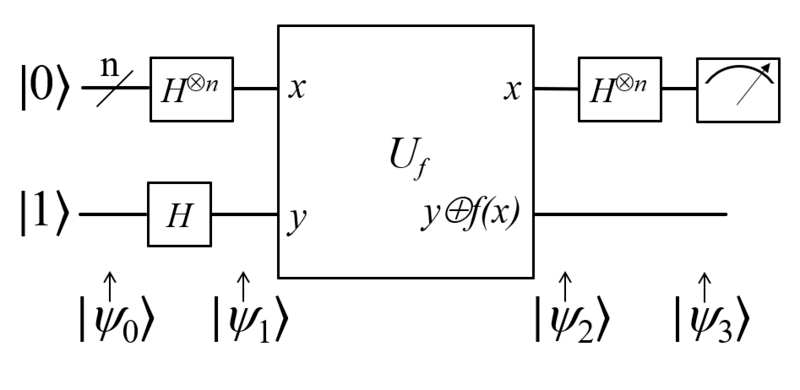

Now, let's go through the steps of the algorithm, notice that the names $|\psi_i\rangle$ in the picture above correspond to the states at each step:

<ol>
   <li>
        Prepare two quantum registers. The first is an $n$-qubit register initialized to $|0\rangle$, and the second is a one-qubit register initialized to $|1\rangle$:
        

$$\vert \psi_0 \rangle = \vert0\rangle^{\otimes n} \vert 1\rangle$$


   </li>
    
   <li>
        Apply a Hadamard gate to each qubit:
        

$$\vert \psi_1 \rangle = \sum_{i=0}^{2^n-1} \vert +_i\rangle |-\rangle $$

This is equivalent to imagining a $2^{n-1}$ register storing the binary integers as $x$ and having a superposition of all values of $x$ plus one extra  qubit:
$$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle \left(|0\rangle - |1 \rangle \right)$$
   </li>
   
   <li>
        Apply the quantum oracle
        $| x\rangle | y\rangle$ to
        $| x\rangle | y \oplus f(x)\rangle $:<br>
        \begin{align}
            \lvert \psi_2 \rangle  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle (\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) \\  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle ( |0\rangle - |1\rangle )
        \end{align}
       
since for each $x$, $f(x)$ is either $0$ or $1$.  Pause for a moment and think about this step, because it really is most of the magic.  We have called the function $f$ once, but effectively in parallel computed its value for every $x$.  This is the *quantum parallelism* that sometimes is stated to lead to the power of quantum computers.
   </li>

   <li>
       At this point the second single qubit register may be ignored. Apply a Hadamard gate to each qubit in the first register, we get a new sum:
        \begin{align}
            \lvert \psi_3 \rangle
                & = \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}
                    \left[ \sum_{z=0}^{2^n-1}(-1)^{x \cdot z}
                    \vert y \rangle \right] \\
                & = \frac{1}{2^n}\sum_{z=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot z} \right]
                    \vert z \rangle
        \end{align}
       
where $x \cdot y = x_0z_0 \oplus x_1z_1 \oplus \ldots \oplus x_{n-1}z_{n-1}$ is the sum of the bitwise product.
   </li>

   <li>
       Measure the first register. Notice that the probability of measuring $\vert 0 \rangle ^{\otimes n} = \lvert \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)} \rvert^2$, which evaluates to $1$ if $f(x)$ is constant and $0$ if $f(x)$ is balanced.
   </li>

</ol>

### 1.4 Why Does This Work? <a id='why-does-this-work'> </a>

- **Constant Oracle**

When the oracle is *constant*, it has no effect (up to a global phase) on the input qubits, and the quantum states before and after querying the oracle are the same. Since the H-gate is its own inverse, in Step 4 we reverse Step 2 to obtain the initial quantum state of $|00\dots 0\rangle$ in the first register.

$$
H^{\otimes n}\begin{bmatrix} 1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}
=
\tfrac{1}{\sqrt{2^n}}\begin{bmatrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}
\quad \xrightarrow{\text{after } U_f} \quad
H^{\otimes n}\tfrac{1}{\sqrt{2^n}}\begin{bmatrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}
=
\begin{bmatrix} 1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}
$$

- **Balanced Oracle**

After step 2, our input register is an equal superposition of all the states in the computational basis. When the oracle is *balanced*, phase kickback adds a negative phase to exactly half these states:

$$
U_f \tfrac{1}{\sqrt{2^n}}\begin{bmatrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}
=
\tfrac{1}{\sqrt{2^n}}\begin{bmatrix} -1 \\ 1 \\ -1 \\ \vdots \\ 1 \end{bmatrix}
$$


The quantum state after querying the oracle is orthogonal to the quantum state before querying the oracle. Thus, in Step 4, when applying the H-gates, we must end up with a quantum state that is orthogonal to $|00\dots 0\rangle$. This means we should never measure the all-zero state.


## 2. Worked Example  <a id='example'></a>

Let's go through a specific example for a two bit balanced function:

<ol>
    <li> The first register of two qubits is initialized to $|00\rangle$ and the second register qubit to $|1\rangle$
        
(Note that we are using subscripts 1, 2, and 3 to index the qubits. A subscript of "12" indicates the state of the register containing qubits 1 and 2)
    

$$\lvert \psi_0 \rangle = \lvert 0 0 \rangle_{12} \otimes \lvert 1 \rangle_{3} $$


   </li>
    
   <li> Apply Hadamard on all qubits
    

$$\lvert \psi_1 \rangle = \frac{1}{2} \left( \lvert 0 0 \rangle + \lvert 0 1 \rangle + \lvert 1 0 \rangle + \lvert 1 1 \rangle \right)_{12} \otimes \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3}  $$


   </li>
    
   <li> The oracle function can be implemented as $\text{Q}_f = CX_{13}CX_{23}$,
       \begin{align}
            \lvert \psi_2 \rangle =  \frac{1}{2\sqrt{2}} \left[ \lvert 0 0 \rangle_{12} \otimes \left( \lvert 0 \oplus 0 \oplus 0 \rangle - \lvert 1 \oplus 0 \oplus 0 \rangle \right)_{3} \\
                   \hspace{3cm}+ \lvert 0 1 \rangle_{12} \otimes \left( \lvert 0 \oplus 0 \oplus 1 \rangle - \lvert 1 \oplus 0 \oplus 1 \rangle \right)_{3} \\
                \hspace{3cm}+ \lvert 1 0 \rangle_{12} \otimes \left( \lvert 0 \oplus 1 \oplus 0 \rangle - \lvert 1 \oplus 1 \oplus 0 \rangle \right)_{3} \\
                  \hspace{3cm}+ \lvert 1 1 \rangle_{12} \otimes \left( \lvert 0 \oplus 1 \oplus 1 \rangle - \lvert 1 \oplus 1 \oplus 1 \rangle \right)_{3} \right]
        \end{align}
        
        
   </li>
    
   <li>Simplifying this, we get the following:
       \begin{align}
        \lvert \psi_2 \rangle & = \frac{1}{2\sqrt{2}} \left[ \lvert 0 0 \rangle_{12} \otimes \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3} - \lvert 0 1 \rangle_{12} \otimes \left( \lvert 0 \rangle - \lvert  1 \rangle \right)_{3} - \lvert 1 0 \rangle_{12} \otimes \left( \lvert 0  \rangle - \lvert 1 \rangle \right)_{3} + \lvert 1 1 \rangle_{12} \otimes \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3}  \right] \\
        & = \frac{1}{2} \left( \lvert 0 0 \rangle - \lvert 0 1 \rangle - \lvert 1 0 \rangle + \lvert 1 1 \rangle \right)_{12} \otimes \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3} \\
        & = \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{1} \otimes \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{2} \otimes \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3}
        \end{align}
   </li>
    
   <li> Apply Hadamard on the first register
        

$$ \lvert \psi_3\rangle = \lvert 1 \rangle_{1} \otimes \lvert 1 \rangle_{2} \otimes \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3} $$


   </li>
   
   <li> Measuring the first two qubits will give the non-zero $11$, indicating a balanced function.
   </li>
</ol>

## 3. Creating Quantum Oracles <a id='creating-quantum-oracles'> </a>

Let's see some different ways we can create a quantum oracle.

For an example constant function, it is simple:

$\qquad$ 1. if f(x) = 0, then apply the $I$ gate to the qubit in register 2.  
$\qquad$ 2. if f(x) = 1, then apply the $X$ gate to the qubit in register 2.

For a balanced function, there are many different circuits we can create. One of the ways we can guarantee our circuit is balanced is by performing a CNOT for each qubit in register 1, with the qubit in register 2 as the target. For example:

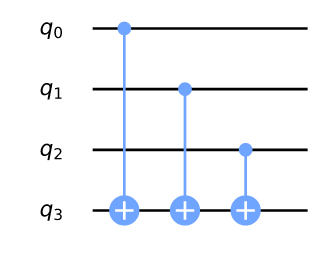

In the image above, the top three qubits form the input register, and the bottom qubit is the output register. We can see which input states give which output in the table below:

| Input states that output 0 | Input States that output 1 |
|:--------------------------:|:--------------------------:|
|             000            |             001            |
|             011            |             100            |
|             101            |             010            |
|             110            |             111            |


We can change the results while keeping them balanced by wrapping selected controls in X-gates. For example, see the circuit and its results table below:

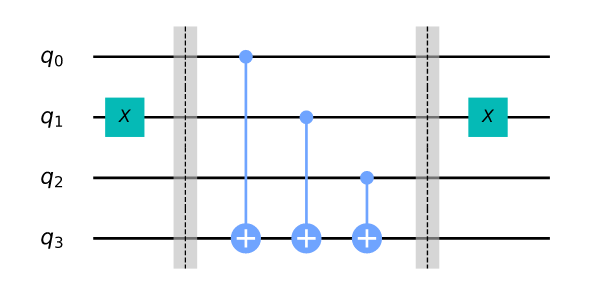

| Input states that output 0 | Input states that output 1 |
|:--------------------------:|:--------------------------:|
|             001            |             000            |
|             010            |             011            |
|             100            |             101            |
|             111            |             110            |

## 4. Qiskit Implementation <a id='implementation'></a>

We now implement the Deutsch-Jozsa algorithm for the example of a three-bit function, with both constant and balanced oracles. First let's do our imports:

In [36]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# import basic plot tools
from qiskit.visualization import plot_histogram

### 4.1 Constant Oracle <a id='const_oracle'></a>
Let's start by creating a constant oracle, in this case the input has no effect on the output so we just randomly set the output qubit to be 0 or 1:

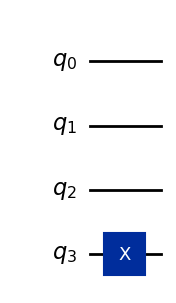

In [37]:
# set the length of the n-bit input string.
n = 3

const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw('mpl')

### 4.2 Balanced Oracle <a id='balanced_oracle'></a>

In [38]:
balanced_oracle = QuantumCircuit(n+1)

Next, we create a balanced oracle. As we saw in section 1b, we can create a balanced oracle by performing CNOTs with each input qubit as a control and the output bit as the target. We can vary the input states that give 0 or 1 by wrapping some of the controls in X-gates. Let's first choose a binary string of length `n` that dictates which controls to wrap:

In [39]:
b_str = "101"

Now we have this string, we can use it as a key to place our X-gates. For each qubit in our circuit, we place an X-gate if the corresponding digit in `b_str` is `1`, or do nothing if the digit is `0`.

* Write some code to place the $X$ gates in a for loop
* Draw the circuit to check

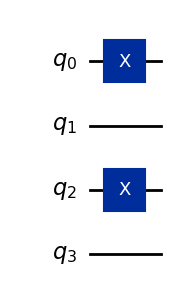

In [40]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for i in range(len(b_str)):
  if int(b_str[i]):
    balanced_oracle.x(i)

# Draw the circuit
balanced_oracle.draw('mpl')


Next, we do our controlled-NOT gates, using each input qubit as a control, and the output qubit as a target.

* Copy the previous code for defining the circuit and adding the x gates.
* Add a barrier
* Add the Cnot gates through the use of a for loop
* Add another barrier
* Draw the circuit

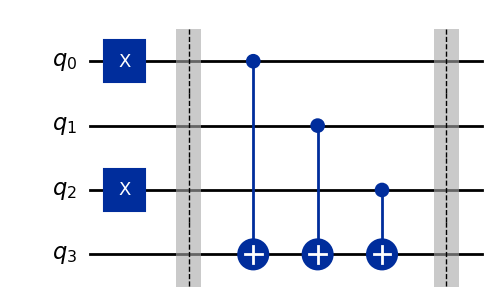

In [41]:
#Copy the old text
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for i in range(len(b_str)):
  if int(b_str[i]):
    balanced_oracle.x(i)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for i in range(3):
  balanced_oracle.cx(i,3)
# Use another barrier
balanced_oracle.barrier()
#Draw stuff
balanced_oracle.draw('mpl')


Finally, we repeat the code from two cells up to finish wrapping the controls in X-gates again.

* This is done by repeating the code for the $X$ gates if there is a 1 in the bit string.

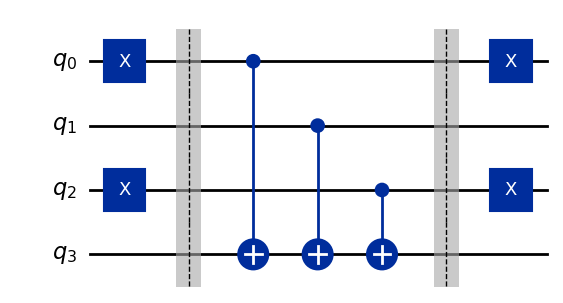

In [42]:
# Copy the old code
#Copy the old text
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for i in range(len(b_str)):
  if int(b_str[i]):
    balanced_oracle.x(i)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for i in range(3):
  balanced_oracle.cx(i,3)
# Use another barrier
balanced_oracle.barrier()


# Repeat the for loop for placing the X-gates
for i in range(len(b_str)):
  if int(b_str[i]):
    balanced_oracle.x(i)

# Draw the oracle

balanced_oracle.draw('mpl')

We have just created a balanced oracle! All that's left to do is see if the Deutsch-Jozsa algorithm can solve it.

### 4.3 The Full Algorithm <a id='full_alg'></a>

Let's now put everything together. This first step in the algorithm is to initialize the input qubits in the state $|{+}\rangle$ and the output qubit in the state $|{-}\rangle$:

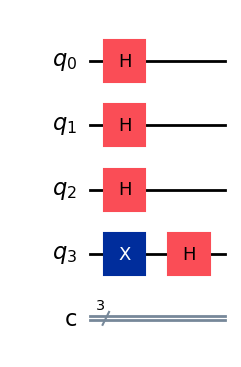

In [43]:
n=3
#define a circuit dj_circuit with n+1 qubits and n classical bits
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates to qubits q_0 through q_n-1
for i in range(n):
  dj_circuit.h(i)

# Put additional qubit q_n in state |->
dj_circuit.x(n)
dj_circuit.h(n)

#Draw the circuit for initialization
dj_circuit.draw('mpl')


In [44]:
lmao = QuantumCircuit(3,2)


Next, let's apply the oracle. Here we apply the `balanced_oracle` we created above:

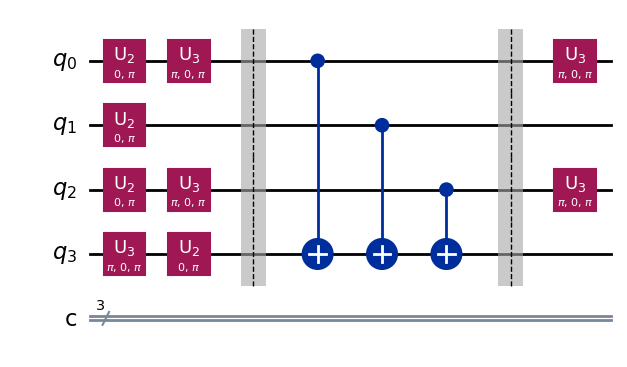

In [48]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle by appending to the circuit
for i in range(len(balanced_oracle)):
  dj_circuit.append(balanced_oracle[i])

# Draw, but decompose so we can see the oracle explictly
dj_circuit.decompose().draw('mpl')

AttributeError: 'NoneType' object has no attribute 'name'

Finally, we perform H-gates on the $n$-input qubits, and measure our input register:

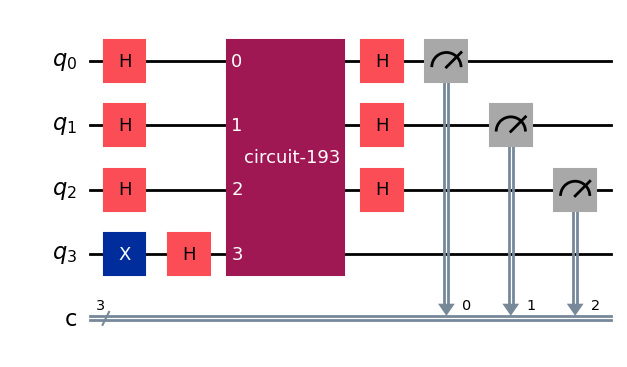

In [51]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit.append(balanced_oracle,range(n+1))

# Repeat H-gates on the 0 -> n-1 qubits, and put up a barrier
for i in range(n):
  dj_circuit.h(i)

# Measure the first n qubits by a for loop and place them into the n classical bits
# this can be done with [CIRCUIT].measure(qubit,bit)
for i in range(n):
  dj_circuit.measure(i,i)


# Display circuit
dj_circuit.draw('mpl')

Let's see the output:

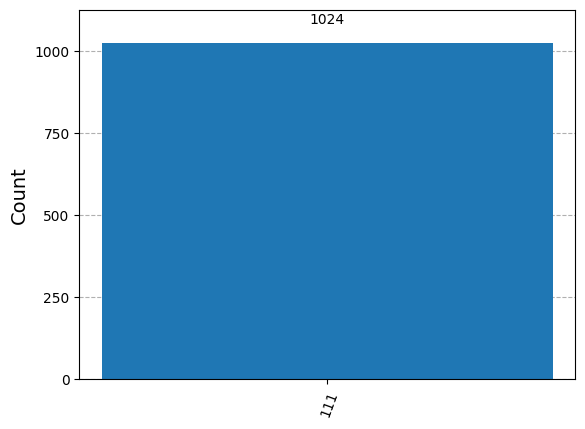

In [52]:
# use local simulator
aer_sim = AerSimulator()
transpiled_circuit = transpile(dj_circuit,aer_sim)
results = aer_sim.run(transpiled_circuit).result()
answer = results.get_counts()

plot_histogram(answer)

We can see from the results above that we have a 0% chance of measuring `000`. This correctly predicts the function is balanced.

### 4.4 Generalised Circuits <a id='general_circs'></a>

Below, we provide a generalised function that creates Deutsch-Jozsa oracles and turns them into quantum gates. It takes the `case`, (either `'balanced'` or '`constant`', and `n`, the size of the input register:

In [59]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    dj_circuit = QuantumCircuit(n+1)
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for i in range(len(b_str)):
          if int(b_str[i]):
            dj_circuit.x(i)


        # Do the controlled-NOT gates for each qubit, using the output qubit
        # as the target:
        for i in range(n):
          dj_circuit.cx(i,n)


        # Next, place the final X-gates
        for i in range(len(b_str)):
          if int(b_str[i]):
            dj_circuit.x(i)


    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        # if output is 1, place an x gate on the n qubit.
        if output:
          dj_circuit.x(n)

    #Here is syntax to actually turn the oracle into a gate, and then give it a name
    oracle_gate = dj_circuit.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

Let's also create a function that takes this oracle gate and performs the Deutsch-Jozsa algorithm on it:

In [68]:
def dj_algorithm(oracle, n):
    #define a circuit with n+1 qubits and n bits
    dj_circuit = QuantumCircuit(n+1,n)
    # Set up the additional qubit to be in the |-> state:
    dj_circuit.x(n)
    dj_circuit.h(n)

    # And set up the input register with Hadamards:
    for i in range(n):
      dj_circuit.h(i)

    dj_circuit.barrier()

    # Let's append the oracle gate to our circuit, noting that it has n+1 qubits:
    dj_circuit.append(oracle,range(n+1))
    # Finally, perform the H-gates again and measure:
    dj_circuit.barrier()

    for i in range(n):
      dj_circuit.h(i)

    for i in range(n):
      dj_circuit.measure(i,i)

    return dj_circuit

Finally, let's use these functions to play around with the algorithm:

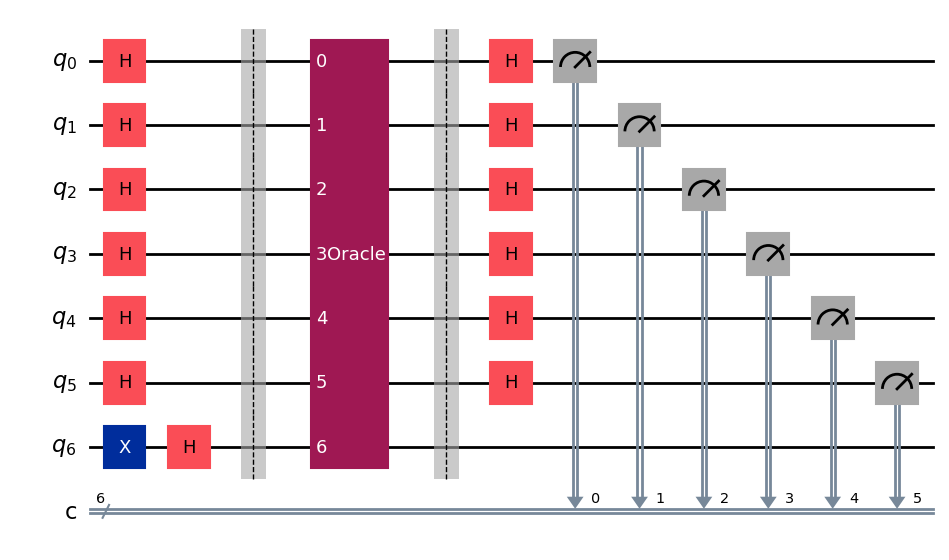

In [69]:
n = 6
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw('mpl')

And see the results of running this circuit:

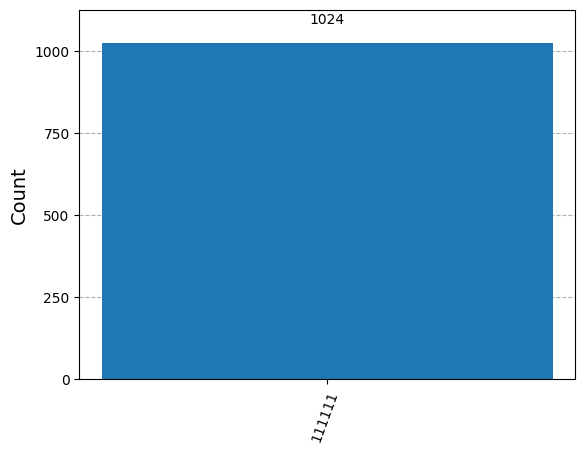

In [70]:
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
results = aer_sim.run(transpiled_dj_circuit).result()
answer = results.get_counts()
plot_histogram(answer)

## 5. Experiment with Real Devices <a id='device'></a>

We can run the circuit on the real device as you will see, but first let's test things on a simulator with noise.

In [71]:
backend = GenericBackendV2(num_qubits=7,coupling_map=[[0,1],[1,2],[1,3],[3,5],[4,5],[5,6]])

transpiled_circuit = transpile(dj_circuit,backend, optimization_level=3)
job = backend.run(transpiled_dj_circuit)
transpile

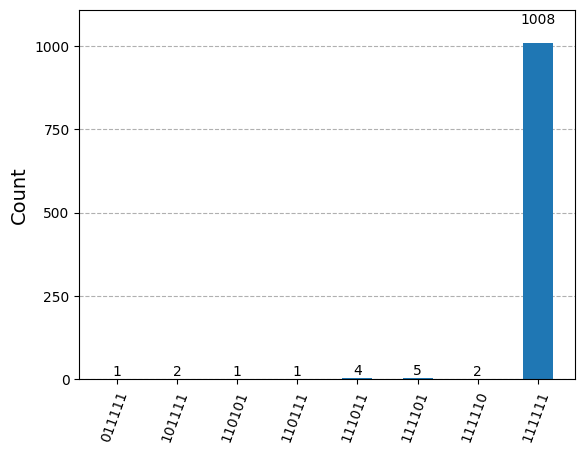

In [72]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

As we can see, the most likely result is `1111`. The other results are due to errors in the quantum computation. As we can see, the most likely result is `1111`. The other results are due to errors in the quantum computation.  Now, lets make a real oracle and <b>see if you can recognize what type of function you have been passed on a real device</b>.

* In the next cell, set a variable `n_qubits` to a number between 6 and 20
* Define an array `choose_oracle` with two elements, `'balanced'` and `'constant'`
* Set a variable `oracle_value` to be a random pick from the array `choose_oracle`.  This can be done with a function like `np.random.choice`
* Using `oracle_value` and `n_qubits` define a circuit that implements Deutsch-Josza algorithm, and draw it -- without decomposing the oracle -- to check things are ok.

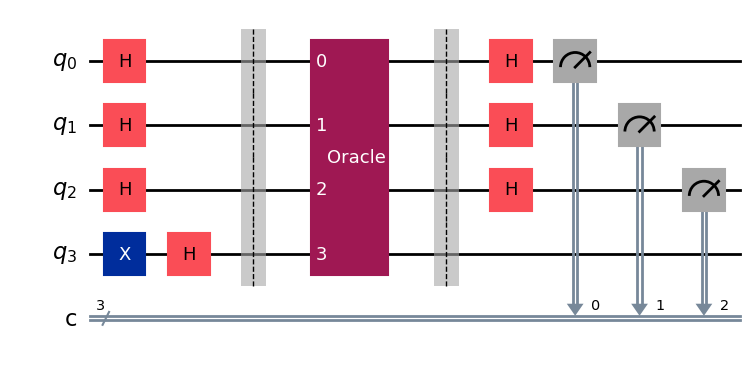

In [84]:
n_qubits = 3
choose_oracle = ['balanced', 'constant']
oracle_value = np.random.choice(choose_oracle)

oracle_gate = dj_oracle(oracle_value, n_qubits)

dj_circuit = dj_algorithm(oracle_gate, n_qubits)
dj_circuit.draw('mpl')

In [85]:
from qiskit_ibm_runtime import QiskitRuntimeService

token='6aaba147462abf70fa8658fd3d05c94a9c5d37f31ae2be435b268d298464b8cf7a0adc790991093d6eef7e4c2fce3b2316d28a7caf70eaedae027f5128788933'
QiskitRuntimeService.delete_account()
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
service = QiskitRuntimeService()

service.least_busy(simulator=False)

<IBMBackend('ibm_osaka')>

The previous cell may give you issues. Do not proceed until
* You see text like `<IBMBackend('ibm_[CITYNAME]')>` with the name of a world city being printed from this cell
* **You call a lab instructor over**.

Run the following cell, which should use a fake backend to simulate your circuit.  **IF it works without error...**

* Comment out the line for `backend = GenericBackendV2(num_qubits=n_qubits+1)`
* Uncomment the second line, which will set your backend to be a **real quantum computer**
* Run the cell again.  This should send your job to the quantum computer, and will eventually return a result.

In my recent experience, the real devices are quite oversubscribed, so this code might take several hours to run.  Sorry, thats just how few quantum computers there are compared to the people that want to use them.

The cell below should have printed `Job ID: [SOME LETTERS AND NUMBERS]` copy these down somewhere in case you don't get your results back from IBM before you disconnect from Google Colab, so you can recover your results later.

In [86]:
#backend = GenericBackendV2(num_qubits=n_qubits+1)
backend = service.least_busy(simulator=False)
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
transpiled_circuit = pm.run(dj_circuit)

#Set up the Sampler with backend
sampler = Sampler(backend=backend)

#Run the circuits, and get results
job = sampler.run([transpiled_circuit])

print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

<ipython-input-86-7cd25756339a>:7: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend)


>>> Job ID: cstv71mzsqjg008tcnk0
>>> Job Status: QUEUED


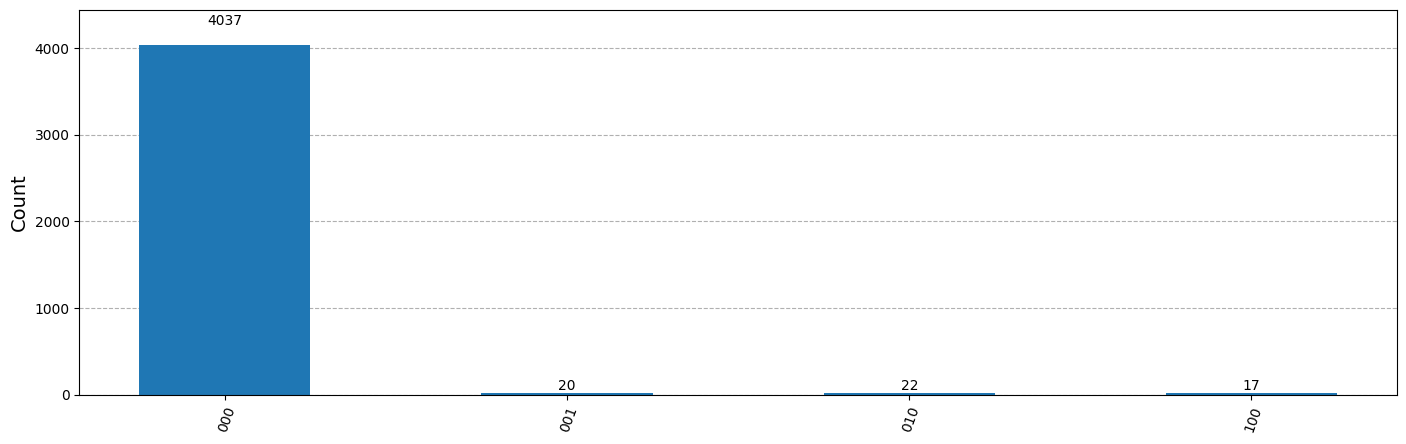

In [87]:
job_id='cstv71mzsqjg008tcnk0'
job = service.job(job_id)
counts=job.result()[0].data.c.get_counts()
#Plot the result.  Now what is the name of the classical bits?
plot_histogram(counts,figsize=(17,5))

If you were ambitious and set `n_qubits` large, the histogram above may be nigh unreadable, because so many different states had a nonzero number of counts on the real device.  As a matter of analysis, lets try to combine this data is some sensible way -- *Hamming distance*.  In information theory, the Hamming distance between two strings or vectors of equal length is the number of positions at which the corresponding symbols are different.

In the noiseless case there are only two valid results $|0\rangle^n$ and $|1\rangle^n$.  Therefore, the Hamming distance from $|0\rangle^n$ -- or the number of 1s in a bitstring -- can intuitively be seen as a measure of which noiseless string $|0\rangle^n$ or $|1\rangle^n$ is more likely to be the origin of a given noisy string.  In the cell below, I have written code to collect your counts based on the Hamming distance from $|0\rangle^n$.  0 represents the $|0\rangle^n$ state, and the maximum value, $n$ represents $|1\rangle^n$ with any other value being a collection of other bitstrings.  

Is the distribution symmetric?  Or is it biased toward 0 or $n$?  Does this help in your analysis of which function you passed in?

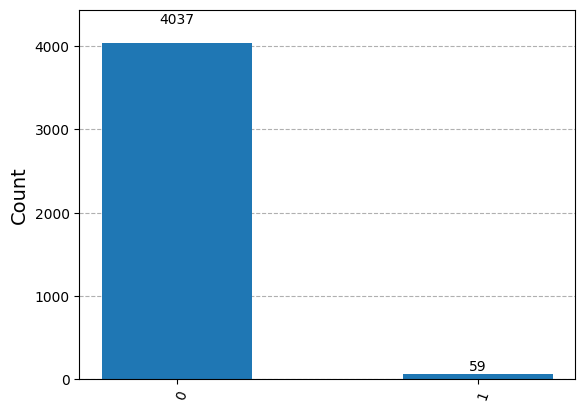

In [88]:
temp = {}
hamming = {}
for k in counts:
  try:
    temp[k.count('1')].append(counts[k])
  except KeyError:
    temp[k.count('1')] = [counts[k]]

for k in temp:
    hamming[k] = [sum(temp[k])]

plot_histogram(hamming)

Which type of function do you think you ran your computer with?  To check, run the next cell

In [89]:
oracle_value

'constant'